In [1]:
# pip install numpy
import numpy as np

# pip install pandas
import pandas as pd

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install ta
from ta import momentum as mo
from ta import volume as vo
from ta import trend as tr

from time import time, sleep

In [2]:
config = {
    "yahoo_fin": {
        "symbol": "btc-usd",
        "key_adjusted_close": "Adj Close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.98,
        "technical_slice": 50
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 11,
        "num_lstm_layers": 4,
        "lstm_size": 16,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",  # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 120,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Number data points: 2550 from 2014-11-10 to 2021-11-02


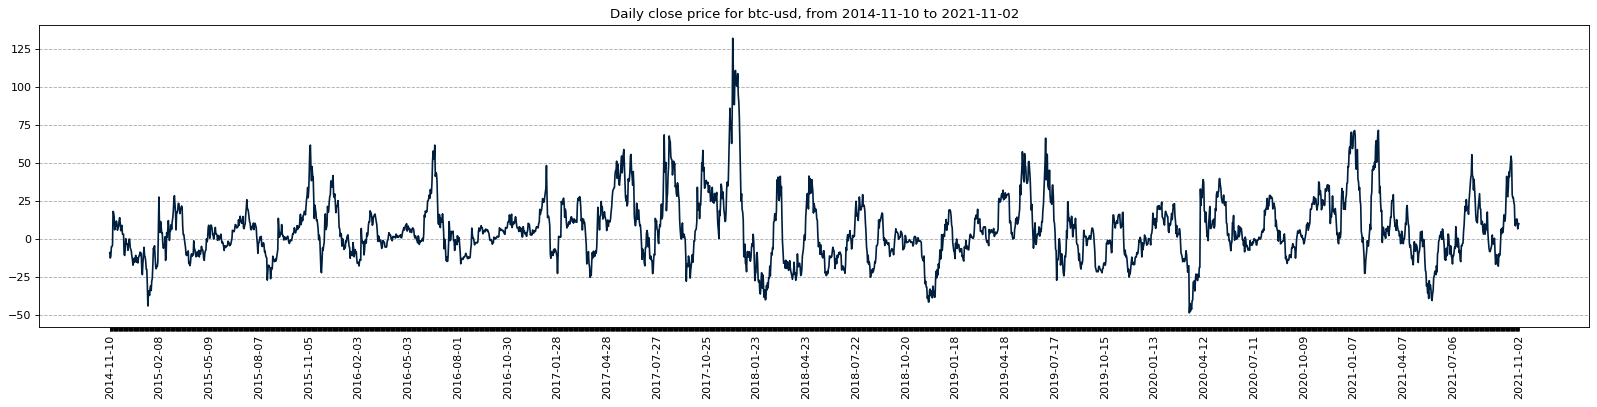

In [3]:
# calculate all indicators for model
def calculate_technical_analysis(closes_data):
    # data = pd.DataFrame([
    #     closes_data[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=5).values[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=10).values[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=15).values[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=20).values[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=25).values[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=30).values[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=35).values[50:],
    #     tr.ema_indicator(pd.Series(closes_data), window=40).values[50:],
    #     mo.roc(pd.Series(closes_data), window=1).values[50:]
    # ]).transpose().values

    # data = pd.DataFrame([
    #     mo.roc(pd.Series(closes_data), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=2)), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=3)), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=4)), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=5)), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=6)), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=7)), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=8)), window=1).values[50:],
    #     mo.roc(pd.Series(tr.ema_indicator(pd.Series(closes_data), window=9)), window=1).values[50:],
    # ]).transpose().values

    data = pd.DataFrame([
        mo.roc(pd.Series(closes_data), window=20).values[50:],
        mo.roc(pd.Series(closes_data), window=18).values[50:],
        mo.roc(pd.Series(closes_data), window=16).values[50:],
        mo.roc(pd.Series(closes_data), window=14).values[50:],
        mo.roc(pd.Series(closes_data), window=12).values[50:],
        mo.roc(pd.Series(closes_data), window=10).values[50:],
        mo.roc(pd.Series(closes_data), window=8).values[50:],
        mo.roc(pd.Series(closes_data), window=6).values[50:],
        mo.roc(pd.Series(closes_data), window=4).values[50:],
        mo.roc(pd.Series(closes_data), window=2).values[50:],
        mo.roc(pd.Series(closes_data), window=1).values[50:],
    ]).transpose().values

    return data

def download_data(config, plot=False):
    # get the data from yahoo finance
    data = pd.read_csv(
        f'https://query1.finance.yahoo.com/v7/finance/download/{config["yahoo_fin"]["symbol"]}?period1=1&period2={round(time())}&interval=1d&events=history&includeAdjustedClose=true')

    data_close_price = data.iloc[:, 5].values
    data_close_price = data_close_price[~np.isnan(data_close_price)]
    data_ta = calculate_technical_analysis(data_close_price)

    data_date = data.iloc[data.shape[0]-data_ta.shape[0]:, 0].values

    num_data_points = data_ta.shape[0]
    display_date_range = "from " + data_date[0] + " to " + data_date[-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, pd.DataFrame(data_ta).iloc[:, 0], color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["yahoo_fin"]["symbol"] + ", " + display_date_range)
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_ta, num_data_points

data_date, data, num_data_points = download_data(config, plot=config["plots"]["show_plots"])

In [4]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x, column=False, index=0):
        if column:
            return (x*self.sd[0][index]) + self.mu[0][index]

        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data = scaler.fit_transform(data)

pd.DataFrame(normalized_data)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.738331,-0.831814,-0.821302,-0.413541,-0.198716,-0.301625,0.155464,0.157984,0.772818,0.932698,0.665062
1,-0.913617,-0.843849,-0.879369,-0.532028,-0.476659,-0.548089,-0.271988,0.350516,0.435323,0.054735,-0.574612
2,-0.853525,-0.846238,-0.476172,-0.286688,-0.384635,0.005910,-0.015174,0.442653,0.435388,-0.300314,0.156944
3,-0.547012,-0.558393,-0.190400,-0.104073,-0.130199,0.179165,0.801508,0.944933,0.750398,1.005649,1.241297
4,-0.544251,-0.156096,0.055583,-0.008331,0.402739,0.429491,0.894849,0.957419,0.500653,1.026710,0.185046
...,...,...,...,...,...,...,...,...,...,...,...
2545,0.359432,0.156447,0.213376,-0.190425,-0.163396,-0.464533,-0.196774,-0.035487,-0.308552,1.063114,0.604054
2546,0.348908,0.272560,0.188061,-0.152525,-0.253856,-0.699484,-0.027937,-0.013578,0.178559,0.277944,-0.211277
2547,0.036009,0.080632,-0.294792,-0.278439,-0.553267,-0.331223,-0.209827,-0.455560,0.475338,-0.368052,-0.307215
2548,0.144195,0.059338,-0.258596,-0.357428,-0.757934,-0.181427,-0.188767,-0.066078,-0.063554,-0.362281,-0.203105


In [5]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size,x.shape[1]), strides=(x.strides[0],x.strides[0],x.strides[1]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x.transpose()[0].transpose()[window_size:]
    return output

def prepare_data(data, config):
    data_x, data_x_unseen = prepare_data_x(data, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(data, window_size=config["data"]["window_size"])
    print(data_x.shape)
    print(data_y.shape)

    # split dataset
    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data, config)

print(split_index)
print(data_x_train.shape)
print(data_y_train.shape)


(2530, 20, 11)
(2530,)
2479
(2479, 20, 11)
(2479,)


In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        # x = np.expand_dims(x, 2) # if we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (2479, 20, 11) (2479,)
Validation data shape (51, 20, 11) (51,)


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [8]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/120] | loss train:0.147929, test:0.002295 | lr:0.010000
Epoch[2/120] | loss train:0.067497, test:0.001909 | lr:0.010000
Epoch[3/120] | loss train:0.062751, test:0.002184 | lr:0.010000
Epoch[4/120] | loss train:0.058742, test:0.001914 | lr:0.010000
Epoch[5/120] | loss train:0.056367, test:0.001972 | lr:0.010000
Epoch[6/120] | loss train:0.046929, test:0.001632 | lr:0.010000
Epoch[7/120] | loss train:0.047189, test:0.001678 | lr:0.010000
Epoch[8/120] | loss train:0.050925, test:0.002094 | lr:0.010000
Epoch[9/120] | loss train:0.045289, test:0.001606 | lr:0.010000
Epoch[10/120] | loss train:0.048673, test:0.001595 | lr:0.010000
Epoch[11/120] | loss train:0.045155, test:0.001713 | lr:0.010000
Epoch[12/120] | loss train:0.040884, test:0.001446 | lr:0.010000
Epoch[13/120] | loss train:0.045708, test:0.002050 | lr:0.010000
Epoch[14/120] | loss train:0.042989, test:0.001504 | lr:0.010000
Epoch[15/120] | loss train:0.043859, test:0.001616 | lr:0.010000
Epoch[16/120] | loss train:0.04252

2499


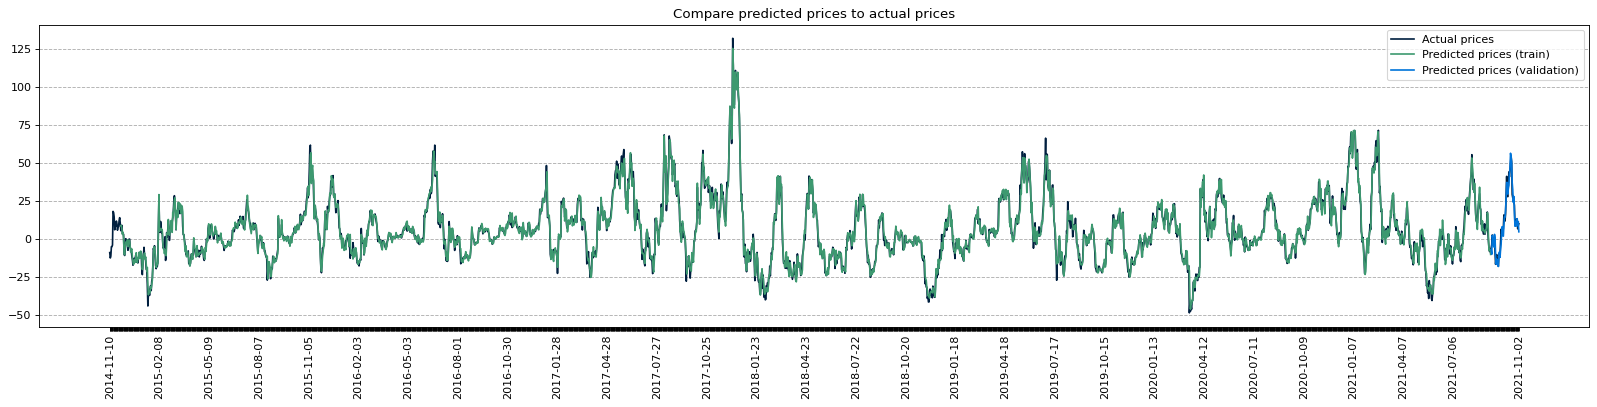

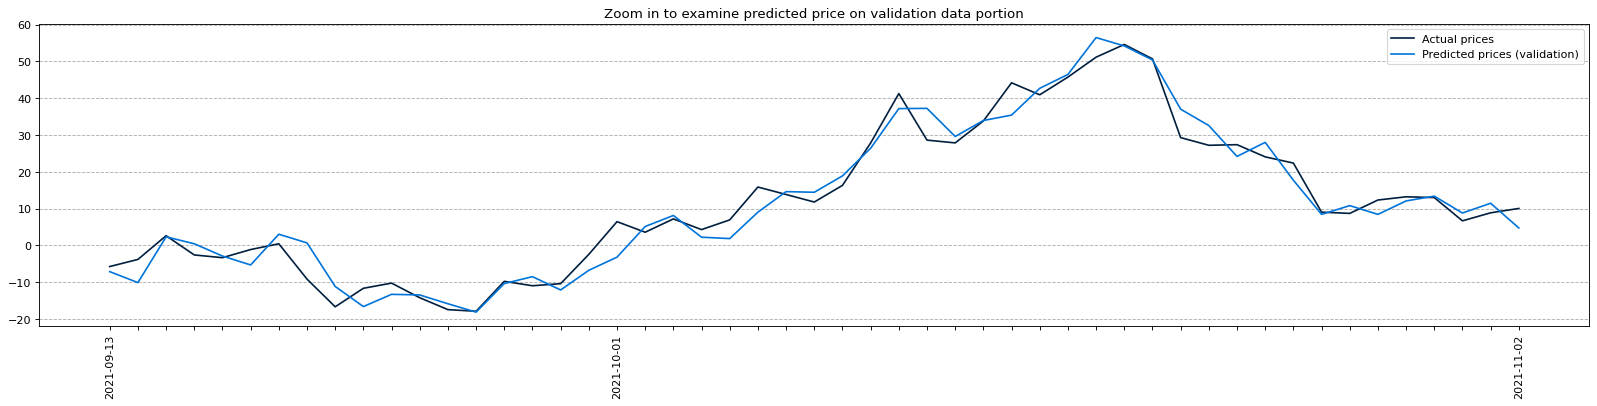

In [9]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train, column=True, index=0)
    print(split_index+config["data"]["window_size"])
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val, column=True, index=0)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, pd.DataFrame(data).iloc[:, 0].values, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val, column=True, index=0)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val, column=True, index=0)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

torch.Size([1, 20, 11])


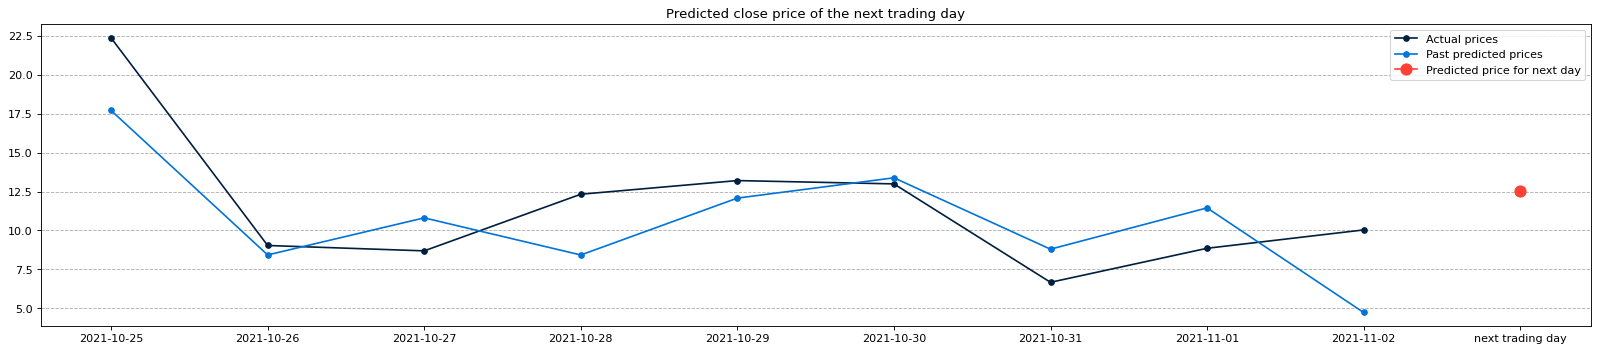

Predicted close price of the next trading day: 12.55


In [10]:
# predict on the unseen data, tomorrow's price

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0) # this is the data type and shape required, [batch, sequence, feature]
print(x.shape)
# prediction = model(x * 1.0225)
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction,column=True,index=0)[0]

if config["plots"]["show_plots"]:

    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val,column=True,index=0)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val,column=True,index=0)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = np.append(data_date[-plot_range+1:], "next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

In [11]:
# pred_closes = pd.DataFrame(data).iloc[:,0].values
# pred_closes = np.append(pred_closes, prediction)
# pred_data, roc = calculate_technical_analysis(pred_closes)

# pred_scaler = Normalizer()
# pred_norm_data = pred_scaler.fit_transform(pred_data)
# pred_data_x, pred_data_x_unseen = prepare_data_x(pred_norm_data, window_size=config["data"]["window_size"])

# model.eval()

# pred_x = torch.tensor(pred_data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0) # this is the data type and shape required, [batch, sequence, feature]

# pred_prediction = model(pred_x*1.0225)
# pred_prediction = pred_prediction.cpu().detach().numpy()
# pred_prediction = pred_scaler.inverse_transform(pred_prediction,column=True,index=0)[0]

# print("Predicted close price of the second trading day:", round(pred_prediction, 2))

In [12]:
# torch.save(model.state_dict(), "models/lstm/test.pt")

# loaded_model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
# loaded_model.load_state_dict(torch.load("models/lstm/test.pt"))
# loaded_model.eval()

# pred_closes = pd.DataFrame(data).iloc[:,0].values
# pred_closes = np.append(pred_closes, 791.26)
# pred_data = calculate_technical_analysis(pred_closes)

# pred_scaler = Normalizer()
# pred_norm_data = pred_scaler.fit_transform(pred_data)
# pred_data_x, pred_data_x_unseen = prepare_data_x(pred_norm_data, window_size=config["data"]["window_size"])

# loaded_model.eval()

# pred_x = torch.tensor(pred_data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0) # this is the data type and shape required, [batch, sequence, feature]

# pred_prediction = loaded_model(pred_x)
# pred_prediction = pred_prediction.cpu().detach().numpy()
# pred_prediction = scaler.inverse_transform(pred_prediction,column=True,index=0)[0]

# print("Predicted close price of the second trading day:", round(pred_prediction, 2))